Importamos las librerias a utilizar

In [13]:
import pandas as pd
import os
import glob

Damos la ruta de los archivos

In [14]:
path = 'Etiquetas'

Cargamos nuestros archivos

In [15]:
files = os.path.join("Etiquetas", "*.csv")
files = glob.glob(files)
df = pd.concat(map(pd.read_csv, files), ignore_index=False)
df = df[["etiqueta", "x1", "y1", "x2", "y2", "imagen", "w", "h"]]

In [16]:
df

,etiqueta,x1,y1,x2,y2,imagen,w,h
0,borde_izquierdo,4,418,302,378,2019_10_26_120345_001_resized.png,960.0,540
1,borde_derecho,952,406,598,374,2019_10_26_120345_001_resized.png,960.0,540
2,linea_carril,264,494,419,372,2019_10_26_120345_001_resized.png,960.0,540
3,linea_carril,750,523,497,388,2019_10_26_120345_001_resized.png,960.0,540
4,linea_carril,942,432,606,388,2019_10_26_120345_001_resized.png,960.0,540
5,linea_carril,4,429,278,386,2019_10_26_120345_001_resized.png,960.0,540
6,borde_izquierdo,1,415,292,379,2019_10_26_120345_002_resized.png,960.0,540
7,borde_derecho,953,409,591,374,2019_10_26_120345_002_resized.png,960.0,540
8,linea_carril,0,432,295,386,2019_10_26_120345_002_resized.png,960.0,540
9,linea_carril,276,491,418,370,2019_10_26_120345_002_resized.png,960.0,540


Creamos la funcion para extraer los valores de la imagen

In [21]:
# Funcion para extraer la subcadena i-esima de la tupla
def parametroImagen(subCadena):
    """ 
    Documentar lo siguiente
    Input:
    -------    
    Output:    
    """
    Pc = 1
    c1, c2, c3, c4 = 0, 0, 0, 0
    if subCadena[0] == 'linea_carril': 
        c1 = 1
    elif subCadena[0] == 'linea_emergencia': 
        c2 = 1  
    elif subCadena[0] == 'borde_izquierdo': 
        c3 = 1
    elif subCadena[0] == 'borde_derecho': 
        c4 = 1
    x1 = subCadena[1]
    y1 = subCadena[2]
    x2 = subCadena[3]
    y2 = subCadena[4]
    w =  subCadena[6]
    h = subCadena[7]
    return [Pc, c1, c2, c3, c4, x1, y1, x2, y2]

Ahora vamos a juntar en un solo arreglo los datos que correspondan a la misma imagen

In [24]:
# Creamos una lista con los nombres de las imagenes (sin repetir)
nombres  = df['imagen'].unique()
repeticionesPorImagen = []
datosImagenes = []

for nombre in nombres:
    repeticionesPorImagen.append(list(df['imagen']).count(nombre))

# Aqui vamos a crear un arreglo con los datos de una misma imagen
# para recorrernos en todas las imagenes usaremos slices del tipo [n, n + x].
n = 0
pivote = 0
for pivoteTemp in repeticionesPorImagen:
    pivote = pivoteTemp + n
    datosImagenes.append(df[n:pivote].values)
    n += pivoteTemp

Vectores generales

In [25]:
datosImagenes[0][1][5]

'2019_10_26_120345_001_resized.png'

In [134]:
VectorGeneral = []
VectorTemp = []
flagEmergencia = 0
lineasTotales = 7
dic_nombre_marcas = {}

# Cargamos las dimensiones de las imagenes de cualquier arreglo
w = datosImagenes[0][0][-2]
h = datosImagenes[0][0][-1]

# Iteramos sobre el numero de datos de imagenes que tenemos
# en este caso son 972
for i in range(len(datosImagenes)):
    # Aqui vamos a iterar sobre los arreglos de datos de cada imagen
    for j in range(len(datosImagenes[i])):   
        # Extraemos la fila de parametros de la imagen dada una etiqueta
        datosImagenVec = parametroImagen(datosImagenes[i][j])
        VectorTemp.append(datosImagenVec)
        # Banderas de BordeIzquierdo, BordeDerecho y LineaDeEmergencia
        flagEmergencia = datosImagenVec[2]
        flagBordeIzquierdo = datosImagenVec[3]
        flagBordeDerecho = datosImagenVec[4]     
    while len(VectorTemp) < lineasTotales:
        # Aqui verificamos si ya tenemos un registro de linea de emergencia
        if flagEmergencia == 0:
            VectorTemp.append([0, 1, 0, 0, 0, 0, 0, 0, 0])
            flagBordeDerecho = 1
        # Aqui verificamos si ya tenemos un registro de borde derecho
        elif flagBordeDerecho == 0:
            VectorTemp.append([0, 0, 0, 0, 1, 0, 0, 0, 0])
            flagBordeDerecho = 1
        # Aqui verificamos si ya tenemos un registro de borde izquierdo
        elif flagBordeIzquierdo == 0:
            VectorTemp.append([0, 0, 0, 1, 0, 0, 0, 0, 0])
            flagBordeIzquierdo = 1
        # Por ultimo agregamos las lineas de carril en las posiciones sobrantes
        else:
            VectorTemp.append([0, 0, 1, 0, 0, 0, 0, 0, 0])
            flagEmergencia = 1 # Dado que ya habremos agregado la linea de Emergancia           
    nombreImagen = datosImagenes[i][j][5]
    dic_nombre_marcas[nombreImagen] = VectorTemp.copy()
    nombreImagen = [datosImagenes[i][j][5]]
    VectorTemp.append(nombreImagen) # Le pasamos el nombre de la imagen
    VectorGeneral.append(VectorTemp) # Cargamos la fila de valores al VectorGeneral
    VectorTemp = [] # Reseteamos nuestro vector temporal
    
    
# Aplanado del vector
VectorGeneralAplanado = []
flat_list = []

for item in VectorGeneral:
    for l in item:
        flat_list += l
    flat_list.extend([w, h])
    VectorGeneralAplanado.append(flat_list)
    flat_list = []

De modo que tenemos el siguiente vector para la imagen No.941

In [130]:
imagenes = VectorGeneral

Ahora vemos el vector aplanado

In [131]:
print(VectorGeneralAplanado[911])

[1, 0, 0, 1, 0, 7, 418, 342, 367, 1, 0, 0, 0, 1, 909, 402, 591, 358, 1, 1, 0, 0, 0, 260, 497, 411, 383, 1, 1, 0, 0, 0, 298, 494, 421, 384, 1, 1, 0, 0, 0, 723, 478, 524, 376, 1, 1, 0, 0, 0, 907, 422, 586, 367, 0, 1, 0, 0, 0, 0, 0, 0, 0, '2019_12_08_222329_006_resized.png', 960.0, 540]


In [132]:
pd.DataFrame(VectorGeneralAplanado).to_csv('sample.csv')

In [31]:
df.to_csv('out.zip', index=False)  

In [32]:
## Entreno 777, testeo 194

In [33]:
pd.DataFrame(VectorGeneralAplanado[:777]).to_csv('set_entreno.csv')
pd.DataFrame(VectorGeneralAplanado[777:]).to_csv('set_prueba.csv')

## TODO:
-  ~~Dejar solo un parametro $w$ y $h$ para el arreglo __Prueba[i]__~~
- ~~Determinar como calcular $P_c$~~
- ~~Asegurarse de que cada $i$-esimo subtable de la tabla general contenga 65 elementos~~
- ~~Refactorizar y simplificar codigo existente~~
- ~Escribir $\LaTeX$~
- Documentar

---

## Dibujado de lineas en imagenes.

El objetivo de esta seccion es dibujar las lineas en las imagenes dado su vector $y_n$ obtenido en la sección anterior.

Vamos a definir un codigo de colores para la clafisicación de cada una de las lineas.
- Azul: Carril
- Verde: Borde derecho, Borde Izquierdo
- Amarillo: Linea de emergencia

In [34]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import random


Bad key "legend.title_fontsize" on line 22 in
C:\Users\masan\.matplotlib\stylelib\notebook.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [35]:
images_path = 'imagenes/'
posicion_nombre = 63
imagenes = VectorGeneral

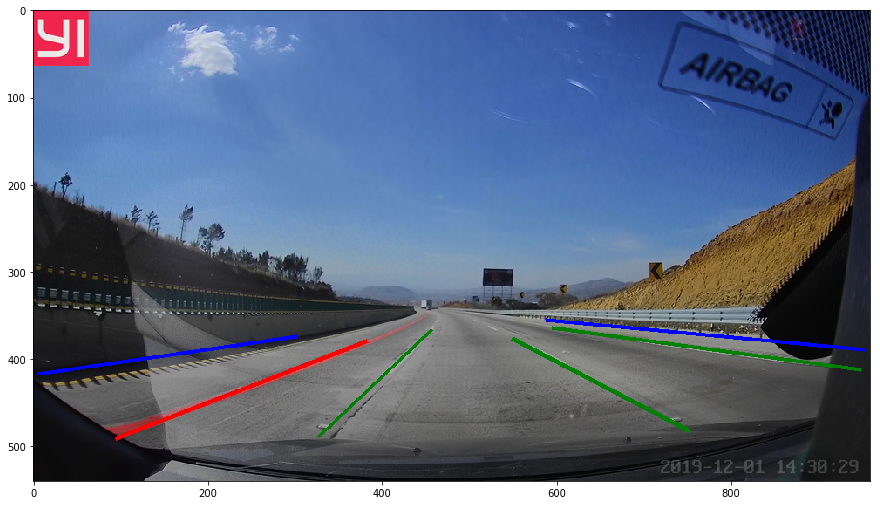

In [38]:
# imagen general

imagen_aleatoria = random.randint(0, len(imagenes))
img = Image.open(images_path + VectorGeneralAplanado[imagen_aleatoria][posicion_nombre])

# imagen sobre la que vamos a dibujar
img1 = ImageDraw.Draw(img)

# Intento 2 - Esperemos que el bueno

for linea in imagenes[imagen_aleatoria][:7]:
    shape = [(linea[5], linea[6]) , (linea[7] , linea[8])]

    # color de la linea
    if linea[1] == 1:
        color = 'green'
    elif linea[2] == 1:
        color = 'red'
    elif linea[3] == 1:
        color = 'blue'
    elif linea[4]  == 1:
        color = 'blue'
    else:
        color = 'red'

    # creamos la linea
    img1.line(shape, fill = color, width = 5)


# despliegue de imagen
fig = plt.figure(figsize=(15,16))
plt.imshow(img)

---

Ahora vamos a preparar los datos para entrenar nuestra red.

In [71]:
import torch
from torch.utils.data import DataLoader
import torchvision
import PIL

In [65]:
n = 100
img_name = imagenes[n][-1][0]
img_puntos = imagenes[n][:-1]

print(f"Name: {img_name}")
print(f"Primeras 3 lineas: {img_puntos[:3]}")

Name: 2019_10_26_121247_025_resized.png
Primeras 3 lineas: [[1, 0, 0, 1, 0, 2, 398, 301, 371], [1, 0, 0, 0, 1, 960, 403, 606, 377], [1, 1, 0, 0, 0, 4, 421, 300, 380]]


In [107]:
nombre_prueba = imagenes[0][-1][0]
imagen_array_test = PIL.Image.open(f"imagenes/{nombre_prueba}")
imagen_array = np.asarray(imagen_array_test)
imagen_array.shape

(540, 960, 3)

Vamos a crear una lista que contenga a las imagenes en forma de arreglo.

In [91]:
# imagenes = {nombre_imagen: array_imagen, .... ,}

In [137]:
dic_nombre_imagen = {}

for i in range(len(imagenes)):
    nombre = imagenes[i][-1][0]
    imagen_array = PIL.Image.open(f"imagenes/{nombre}")
    imagen_array = np.asarray(imagen_array)
    dic_nombre_imagen[nombre] = torch.from_numpy(imagen_array)

In [181]:
nombres_imagenes = []
for i in range(len(imagenes)):
    nombre = imagenes[i][-1][0]
    nombres_imagenes.append(nombre)

In [213]:
dic_test['2019_10_26_121247_025_resized.png'].size()

torch.Size([540, 960, 3])

In [140]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [174]:
def ToTensor(img_name, img_tensor, img_marcas):
    imagen, marcas = img_tensor[img_name], img_marcas[img_name]
    marcas = torch.from_numpy(np.array(marcas))
    return {'image': imagen,
           'marcas': marcas}

In [175]:
ToTensor('2019_10_26_121247_025_resized.png', dic_nombre_imagen, dic_nombre_marcas)['image'].size()

torch.Size([540, 960, 3])

In [178]:
ToTensor('2019_10_26_121247_025_resized.png', dic_nombre_imagen, dic_nombre_marcas)['marcas'].size()

torch.Size([7, 9])

Prueba de datos

In [196]:
transformed_dataset = []
for i in range(len(imagenes)):
    nombre = nombres_imagenes[i]
    imagen = ToTensor(nombre, dic_nombre_imagen, dic_nombre_marcas)['image']
    marcas = ToTensor(nombre, dic_nombre_imagen, dic_nombre_marcas)['marcas']                                                                    
    transformed_dataset.append({'image': imagen, 
                                'marcas': marcas})

In [199]:
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['marcas'].size())

0 torch.Size([540, 960, 3]) torch.Size([7, 9])
1 torch.Size([540, 960, 3]) torch.Size([7, 9])
2 torch.Size([540, 960, 3]) torch.Size([7, 9])
3 torch.Size([540, 960, 3]) torch.Size([7, 9])


---

Arquitectura de la red.

La arquitectura de la red la vamos a encontrar en modelo.py

In [193]:
from modelo import Net

dropout_prob = 0.5
net = Net(dropout_prob)
net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=5000, bias=True)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=5000, out_features=1024, bias=True)
  (drop6): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=1024, out_features=45, bias=True)
)


## Batching

In [200]:
batch_size = 5
train_loader = DataLoader(transformed_dataset, batch_size, shuffle=True)

In [201]:
train_loader

In [205]:
from torch.autograd import Variable

In [209]:
def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(train_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['marcas']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        # wrap them in a torch Variable
        images = Variable(images)    
        images = images.to(device)

        # forward pass to get net output
        output_pts = net(images)
        images = images.to(device)
        output_pts = output_pts.to(Device)
        #print('net output')
        #print(output_pts.shape)
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        #print('net output reshaped')
        #print(output_pts.shape)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [210]:
test_images, test_outputs, gt_pts = net_sample_output()

RuntimeError: Given groups=1, weight of size [32, 3, 7, 7], expected input[32, 540, 960, 3] to have 3 channels, but got 540 channels instead